In [1]:
# Importing required libraries
import os
import sys
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook


# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# ignore warnings 
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
 

Using TensorFlow backend.


In [2]:
#Getting the input
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()


female_neutral     144
male_neutral       144
female_surprise     96
male_angry          96
male_surprise       96
female_happy        96
female_fear         96
male_disgust        96
male_sad            96
male_happy          96
female_disgust      96
female_sad          96
female_angry        96
male_fear           96
Name: labels, dtype: int64

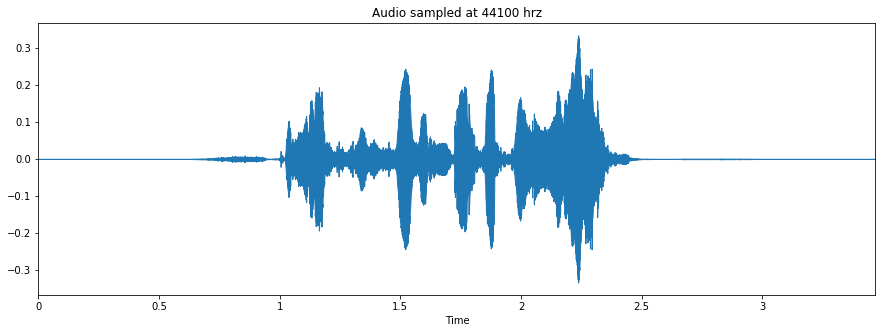

In [4]:
# Pick a random track
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
# # audio wave
# plt.figure(figsize=(20, 15))
# plt.subplot(3,1,1)
# librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')
# Lets play the audio 
ipd.Audio(fname)

In [5]:
df = RAV_df
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_neutral     144
male_neutral       144
female_surprise     96
male_angry          96
male_surprise       96
female_happy        96
female_fear         96
male_disgust        96
male_sad            96
male_happy          96
female_disgust      96
female_sad          96
female_angry        96
male_fear           96
Name: labels, dtype: int64


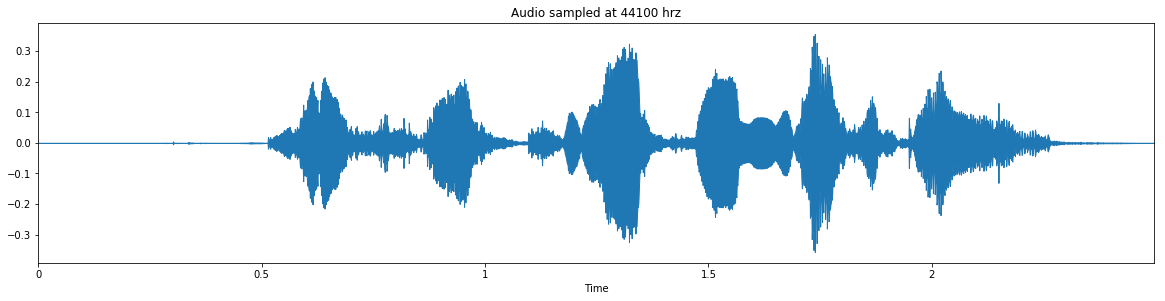

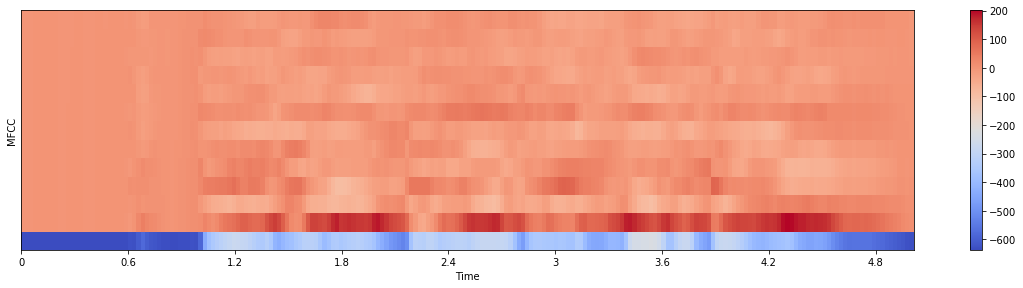

In [6]:
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [7]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("./Data_path.csv")
ref.head()

,labels,source,path
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...


In [8]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1440


,feature
0,"[-69.0514, -69.0514, -69.0514, -69.0514, -69.0..."
1,"[-61.84995, -62.89504, -63.830643, -60.55259, ..."
2,"[-62.10485, -62.10485, -62.10485, -62.03793, -..."
3,"[-73.25497, -73.25497, -73.25497, -73.25497, -..."
4,"[-69.67329, -69.693306, -69.693306, -69.693306..."


In [9]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,...,-59.824612,-57.681641,-56.301266,-58.650139,-63.881084,-63.749409,-65.222466,-65.308243,-67.008553,-68.636299
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-61.849949,-62.895039,-63.830643,-60.552589,-60.821678,-62.073402,-64.889229,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-62.104851,-62.104851,-62.104851,-62.037930,-62.104851,-62.104851,-62.104851,...,-57.709129,-60.357830,-61.090462,-62.026588,-61.804726,-61.251236,-59.135605,-61.459843,-62.104851,-62.104851
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-73.254967,-73.254967,-73.254967,-73.254967,-68.774422,-69.380402,-73.254967,...,-27.190418,-26.499784,-27.143425,-28.207592,-27.193054,-27.315336,-27.431181,-26.716450,-24.115793,-21.873396
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,...,-61.967159,-61.018555,-60.341145,-63.465336,-64.500137,-61.646843,-58.001492,-58.848476,-62.603928,-61.121773


In [10]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(1440, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,...,-59.824612,-57.681641,-56.301266,-58.650139,-63.881084,-63.749409,-65.222466,-65.308243,-67.008553,-68.636299
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-61.849949,-62.895039,-63.830643,-60.552589,-60.821678,-62.073402,-64.889229,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-62.104851,-62.104851,-62.104851,-62.037930,-62.104851,-62.104851,-62.104851,...,-57.709129,-60.357830,-61.090462,-62.026588,-61.804726,-61.251236,-59.135605,-61.459843,-62.104851,-62.104851
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-73.254967,-73.254967,-73.254967,-73.254967,-68.774422,-69.380402,-73.254967,...,-27.190418,-26.499784,-27.143425,-28.207592,-27.193054,-27.315336,-27.431181,-26.716450,-24.115793,-21.873396
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,...,-61.967159,-61.018555,-60.341145,-63.465336,-64.500137,-61.646843,-58.001492,-58.848476,-62.603928,-61.121773


In [11]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1050,-58.548256,-58.226925,-57.321342,-57.009506,-58.561928,-58.653366,-58.140469,-58.824409,-58.950138,-57.578712,...,-42.676659,-41.663162,-44.036079,-46.626587,-47.147305,-47.802803,-50.204781,-54.676796,-53.335102,-53.225651
1089,-62.963749,-61.183235,-65.277870,-66.381317,-66.381317,-62.290604,-60.418827,-64.681870,-61.489075,-55.491928,...,-38.893520,-39.031361,-39.598587,-41.533970,-42.891262,-44.239113,-45.491623,-43.346107,-42.709457,-42.249557
1272,-58.037678,-56.583073,-55.310307,-50.032734,-49.063152,-53.330387,-53.827206,-54.380352,-55.632061,-56.332710,...,-55.803551,-55.854942,-57.655815,-58.334160,-58.334160,-58.334160,-57.917759,-55.107334,-52.934124,-54.693565
1029,-40.588501,-40.581081,-40.605572,-40.649166,-40.645645,-40.654915,-40.655987,-40.645638,-40.632103,-40.652580,...,-38.336983,-37.957699,-37.451443,-39.119526,-39.735306,-40.298763,-40.656857,-40.656857,-40.656857,-40.656857
1336,-60.836601,-60.836601,-60.836601,-60.836601,-60.836601,-60.836601,-60.836601,-60.836601,-60.836601,-60.836601,...,-43.289352,-47.381599,-48.054966,-47.479336,-49.158794,-47.870110,-48.230061,-49.629086,-50.214237,-50.186886
328,-40.790379,-42.031155,-42.240410,-42.021206,-40.180794,-41.091457,-42.873966,-42.277779,-43.592304,-44.333248,...,-41.987495,-41.203293,-40.644192,-41.086723,-43.423447,-44.590515,-44.893639,-45.293762,-44.996841,-44.558186
318,-67.646194,-62.978722,-62.615189,-63.018436,-60.572933,-62.698669,-67.727737,-61.836708,-61.342220,-65.899803,...,-45.509098,-44.881943,-44.635525,-45.581902,-44.708401,-43.917507,-43.180462,-42.649166,-40.031151,-37.451065
1108,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,...,-22.553091,-22.695681,-22.592808,-24.497993,-25.448591,-22.984682,-21.958860,-19.780954,-16.896294,-13.650003
1176,-58.780457,-58.780457,-58.780457,-58.780457,-58.780457,-58.780457,-58.780457,-58.780457,-58.780457,-58.780457,...,-53.177368,-53.421211,-53.154617,-55.451683,-56.329224,-55.669296,-56.554684,-55.602242,-55.444534,-56.373161
12,-67.736153,-67.778023,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,-61.192871,-61.116268,-63.291237,-65.844223,-65.121002,-59.515305,-59.591476,-66.712166,-67.736153,-67.736153


In [12]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std

X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1050,-0.293224,-0.289446,-0.185761,-0.144100,-0.328059,-0.346796,-0.288353,-0.365699,-0.391020,-0.237409,...,0.270316,0.376909,0.193809,-0.000739,-0.029357,-0.069778,-0.249997,-0.611141,-0.492833,-0.461629
1089,-0.804896,-0.635971,-1.129123,-1.252547,-1.247208,-0.773283,-0.553087,-1.045967,-0.687917,0.006851,...,0.594304,0.601641,0.572734,0.437967,0.337368,0.238205,0.156254,0.364055,0.336821,0.312789
1272,-0.234057,-0.096761,0.052677,0.681075,0.788497,0.277355,0.212826,0.150421,-0.003012,-0.091564,...,-0.853874,-0.834944,-0.969203,-1.009293,-0.993280,-0.979924,-0.914818,-0.648196,-0.461525,-0.565198
1029,1.787974,1.778916,1.796139,1.790912,1.777952,1.763628,1.743253,1.745531,1.751047,1.743808,...,0.641966,0.693322,0.756082,0.645961,0.609303,0.578740,0.572987,0.595510,0.497088,0.425162
1336,-0.558400,-0.595340,-0.602546,-0.596748,-0.595441,-0.602793,-0.601630,-0.599389,-0.611618,-0.618748,...,0.217844,-0.111395,-0.149370,-0.074199,-0.202678,-0.075594,-0.079786,-0.176701,-0.249155,-0.247229
328,1.764580,1.608945,1.602305,1.628635,1.832595,1.712441,1.485535,1.555979,1.404888,1.312983,...,0.329336,0.416177,0.483448,0.476495,0.291512,0.207836,0.207797,0.196426,0.158221,0.149904
318,-1.347503,-0.846429,-0.813423,-0.854804,-0.564448,-0.821131,-1.402344,-0.715539,-0.670744,-1.211400,...,0.027745,0.102053,0.142621,0.089256,0.180793,0.265999,0.355464,0.424038,0.545944,0.651347
1108,1.081181,1.063117,1.075003,1.076697,1.067715,1.056239,1.042389,1.043813,1.042910,1.037383,...,1.993703,1.996564,2.024885,1.905539,1.840328,2.075067,2.184662,2.392232,2.352321,2.330632
1176,-0.320131,-0.354328,-0.358760,-0.353559,-0.353747,-0.361698,-0.362716,-0.360594,-0.371178,-0.378074,...,-0.628968,-0.627125,-0.584838,-0.760981,-0.820523,-0.749620,-0.797328,-0.690792,-0.657538,-0.683702
12,-1.357928,-1.408980,-1.303208,-1.202465,-1.406465,-1.411806,-1.403322,-1.345231,-1.418435,-1.426346,...,-1.315417,-1.284215,-1.450420,-1.656251,-1.578073,-1.082001,-1.059085,-1.646987,-1.617272,-1.485419


In [13]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1080, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [14]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 216, 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 256)          

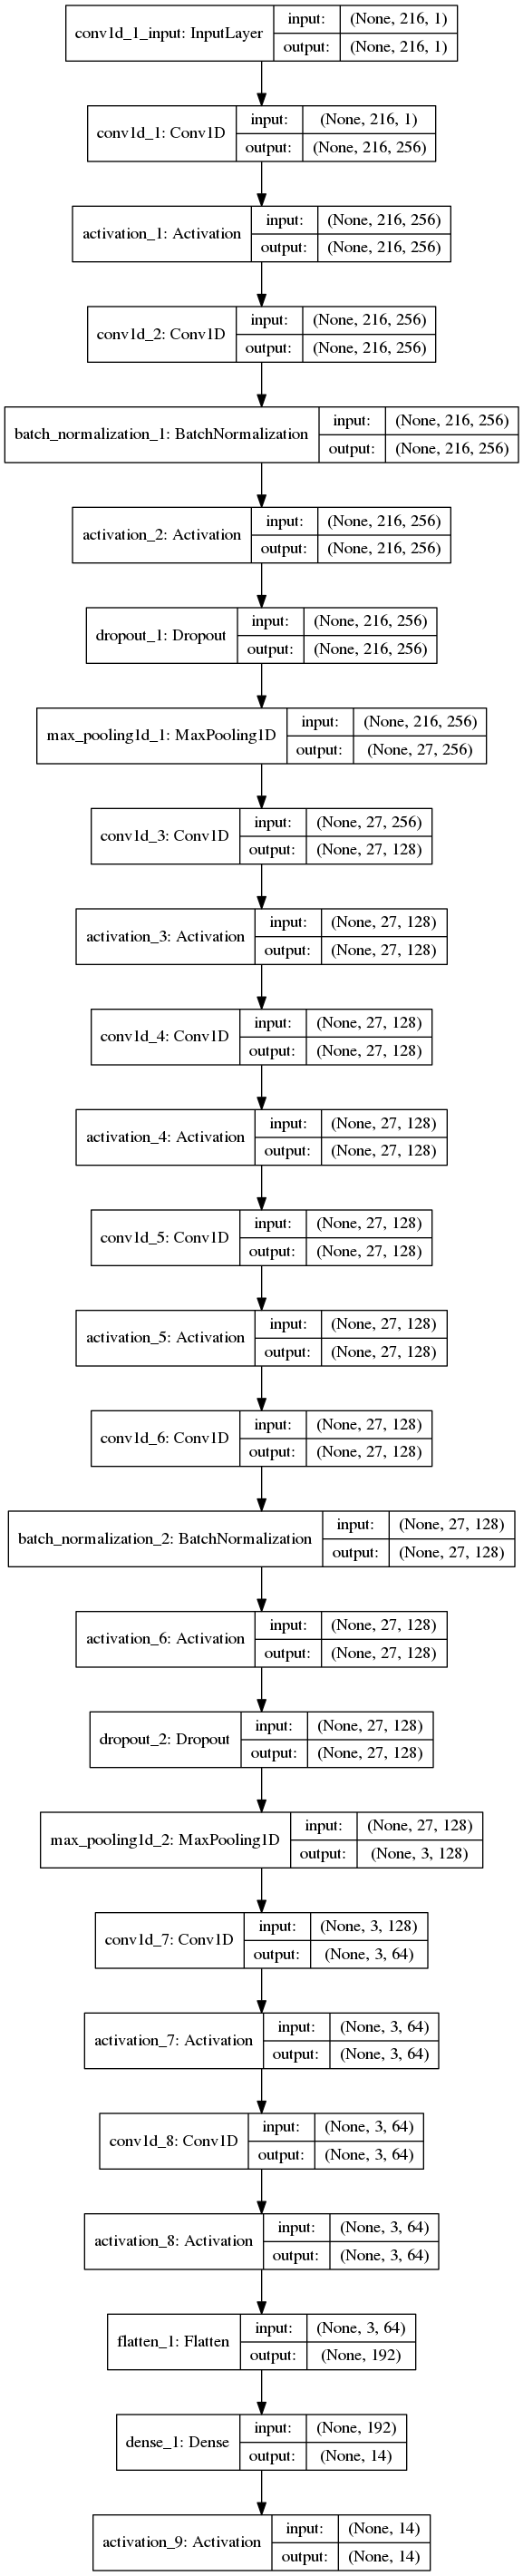

In [15]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data=(X_test, y_test))

Train on 1080 samples, validate on 360 samples
Epoch 1/1000
1080/1080 [==============================] - 4s 4ms/step - loss: 2.5730 - accuracy: 0.1509 - val_loss: 2.6359 - val_accuracy: 0.1028
Epoch 2/1000
1080/1080 [==============================] - 1s 691us/step - loss: 2.4162 - accuracy: 0.2194 - val_loss: 2.6320 - val_accuracy: 0.1028
Epoch 3/1000
1080/1080 [==============================] - 1s 682us/step - loss: 2.3282 - accuracy: 0.2426 - val_loss: 2.6260 - val_accuracy: 0.1028
Epoch 4/1000
1080/1080 [==============================] - 1s 691us/step - loss: 2.2396 - accuracy: 0.2722 - val_loss: 2.6157 - val_accuracy: 0.1028
Epoch 5/1000
1080/1080 [==============================] - 1s 691us/step - loss: 2.1775 - accuracy: 0.2963 - val_loss: 2.5963 - val_accuracy: 0.1278
Epoch 6/1000
1080/1080 [==============================] - 1s 697us/step - loss: 2.1217 - accuracy: 0.3315 - val_loss: 2.5639 - val_accuracy: 0.1722
Epoch 7/1000
1080/1080 [==============================] - 1s 690us/

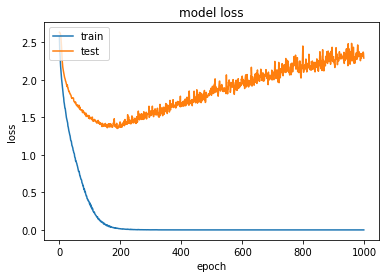

In [17]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/Emotion_Model.h5 


In [19]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 52.22%


In [20]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

360/360 [==============================] - 0s 492us/step


array([ 7, 13,  4,  2,  7,  8,  4,  4,  5, 12, 13,  0,  7,  2,  7,  1,  4,
        9,  4,  5, 12,  2,  4, 11,  2, 11, 11,  4, 13, 13, 12, 13, 12,  7,
        7,  7, 12,  7,  6,  1,  2,  0,  1, 13, 11, 12,  4, 12,  6,  6,  8,
        0, 11,  4,  1,  0,  3,  4, 13, 10,  9,  0,  7,  2,  2,  2,  4, 12,
        4,  1,  6,  0,  6,  5,  4, 10,  8,  9,  8,  0, 10,  5,  0,  7,  4,
        7,  5,  5,  7,  6,  2,  1,  6,  0,  1,  3, 11,  7,  4,  7,  5,  7,
        9, 11,  9,  2,  6,  6,  9, 10,  0,  4,  4, 12,  6,  2, 11,  9, 13,
       10,  0,  4,  2, 10, 11, 11,  9,  0,  4,  4, 11,  7, 13, 11,  6,  9,
        5,  8,  4,  1,  7,  6,  1, 11, 10,  9,  9,  7, 12,  1, 10,  2,  5,
       11,  1,  9,  6, 11, 11,  2,  7,  2,  3,  2,  1,  5, 13,  0,  4,  4,
        6, 10,  4,  2,  9,  0, 10,  7,  8,  5,  4,  2,  1,  4,  4, 11,  5,
        4,  0,  5, 11,  4,  2,  4, 12,  2, 10,  6,  5,  1,  0, 12, 12,  6,
        7,  1,  8,  2, 11, 13, 13, 11,  1,  1,  5, 12,  5,  3,  4, 13,  3,
       11,  2,  6, 12,  2

In [21]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_surprise,female_surprise
171,male_happy,male_happy
172,female_happy,female_neutral
173,female_fear,female_fear
174,male_surprise,male_fear
175,female_angry,female_angry
176,male_happy,male_happy
177,male_angry,male_angry
178,male_disgust,male_disgust
179,female_sad,female_sad


In [22]:
# os.makedirs('../outputs')
# Write out the predictions to disk
finaldf.to_csv("Predictions.csv", index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,24
female_disgust,27
female_fear,33
female_happy,11
female_neutral,46
female_sad,25
female_surprise,29
male_angry,32
male_disgust,10


In [23]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


0.5222222222222223


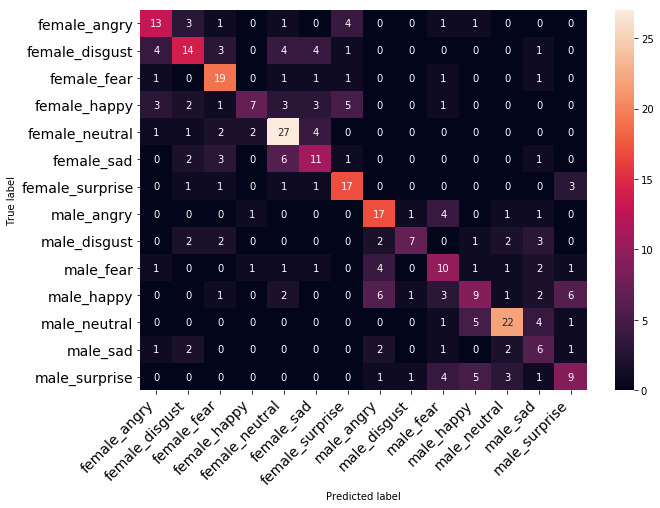

In [24]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [25]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.54      0.54      0.54        24
 female_disgust       0.52      0.45      0.48        31
    female_fear       0.58      0.76      0.66        25
   female_happy       0.64      0.28      0.39        25
 female_neutral       0.59      0.73      0.65        37
     female_sad       0.44      0.46      0.45        24
female_surprise       0.59      0.71      0.64        24
     male_angry       0.53      0.68      0.60        25
   male_disgust       0.70      0.37      0.48        19
      male_fear       0.38      0.43      0.41        23
     male_happy       0.41      0.29      0.34        31
   male_neutral       0.69      0.67      0.68        33
       male_sad       0.27      0.40      0.32        15
  male_surprise       0.43      0.38      0.40        24

       accuracy                           0.52       360
      macro avg       0.52      0.51      0.50       360
   weighted avg       0.53   